In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import choice

class user:
    def __init__(self, name, storage_env_obj, OneDriveUsage=0):
        self.name = name
        self.seo = storage_env_obj
        self.seo.add_user(self)
        self.potential = 1000
        self.available = self.potential - OneDriveUsage
        self.used = OneDriveUsage
        self.membership = {"OneDrive": OneDriveUsage} 
    def __repr__(self):
        return(f"<{self.__class__.__name__} - {self.name}>")
    def add_storage_membership(self, storage_name, storage_usage=0):
        self.membership[storage_name] = storage_usage
        self.seo.add_user_to_storage_space(storage_name, self)
    def evaluate_storage(self):
        self.available = self.potential
        self.used = 0
        for m in self.membership.keys():
            self.available -= self.membership[m]
            self.used += self.membership[m]
    def pp_evaluate_storage(self):
        self.evaluate_storage()
        print(f"{'Available':.<15}{self.available:.>5} GB")
        print(f"{'Used':.<15}{self.used:.>5} GB")
    def pp_storage_usage(self):
        usage_dict = self.membership
        centering_value = max([len(x) for x in usage_dict.keys()])
        centering_number = max([len(str(x)) for x in usage_dict.values()])
        total_centering = centering_number + centering_value + 3
        print(f"{self.name: ^{total_centering}}")
        for storagespace in usage_dict.keys():
            cssu = str(usage_dict[storagespace]) #current storage space usage
            print(f"{storagespace:^{centering_value}} - {cssu:^{centering_number}} GB")
    def pddf(self, show_available=False): #pandas dataframe
        self.evaluate_storage()
        dl = [self.name, self.membership["OneDrive"]] # Data List
        cl = ["Name", "OneDrive"] # Column List
        for service in [x for x in self.membership.keys() if x != "OneDrive"]:
            dl.append(self.membership[service])
            cl.append(service)
        if show_available == True:
            dl.append(self.available)
            cl.append("Available")
        df = pd.DataFrame(dl, columns=cl)
        return(df)
    def total_usage_plot(self):
        self.evaluate_storage()
        n = [self.name]
        u = [self.used]
        a = [self.available]
        plt.bar(n, u, color="blue")
        plt.bar(n, a, bottom=u, color="gray")
        plt.xlabel = "User"
        plt.ylabel = "Usage in GB"
        plt.legend(["Total Used", "Unused"])
        plt.show()
    def usage_by_service_plot(self, show_available=False):
        self.evaluate_storage()
        values = [self.name, self.membership["OneDrive"]]
        service_colors = ["blue"]
        service_names = ["Name", "OneDrive"]
        for service in [x for x in self.membership.keys() if x != "OneDrive"]:
            service_names.append(service)
            values.append(self.membership[service])
            service_colors.append(self.seo.storage_spaces[service].color)
        if show_available == True:
            service_names.append("Available")
            values.append(self.available)
            service_colors.append("gray")
        df = pd.DataFrame([values], columns=service_names)
        df.plot(x="Name", kind="bar", stacked=True, color=service_colors)
        plt.xlabel = "User"
        plt.ylabel = "Usage in GB"
        plt.show()
            
class storage_space:
    def __init__(self, StorageSpaceName, storage_env_obj, storage_type="TeamSite"):
        self.storage_type = storage_type
        self.seo = storage_env_obj
        self.choose_color()
        self.name = StorageSpaceName
        self.potential = 0
        self.used = 0
        self.available = self.potential - self.used
        self.members = {}
    def __repr__(self):
        return(f"<{self.__class__.__name__} - {self.name}>")
    def evaluate_storage(self):
        self.potential = 1000 * len(self.members.keys())
        self.used = 0
        for m in self.members.keys():
            self.members[m].evaluate_storage()
            m_self_usage = self.members[m].membership[self.name]
            m_total_usage = self.members[m].used
            m_self_unsusable = m_total_usage - m_self_usage
            self.used += m_self_usage
            self.potential -= m_self_unsusable
        self.available = self.potential - self.used
    def add_member(self, user_obj):
        self.members[user_obj.name] = user_obj
    def choose_color(self):
        teams = ["#9786ca", "#6951b3", "#6049a7", "#bbb0dd", "#503c8c"]
        sharepoint = ["#3e9eb3", "#317d8d", "#316e8d", "#307485", "#45a4bc"]
        if self.storage_type == "TeamSite":
            self.color = choice([x for x in teams if x not in self.seo.used_colors])
        elif self.storage_type == "SharePoint":
            self.color = choice([x for x in sharepoint if x not in self.seo.used_colors])
    def usage_plot(self):
        self.evaluate_storage()
        n = [self.name]
        u = [self.used]
        a = [self.available]
        plt.bar(n, u, color=self.color)
        plt.bar(n, a, bottom=u, color="gray")
        plt.xlabel = "User"
        plt.ylabel = "Usage in GB"
        plt.legend(["Total Used", "Potentially Unused"])
        plt.title(f"{self.potential} GB Potential")
        plt.show()
            
class storage_environment:
    def __init__(self, name="Utrecht University"):
        self.name = name
        self.users = []
        self.storage_spaces = {}
        self.used_colors = []
    def __repr__(self):
        return(f"<{self.__class__.__name__} - {self.name}>")
    def add_user(self, user_obj):
        self.users.append(user_obj)
    def add_storage_space(self, storage_obj):
        self.storage_spaces[storage_obj.name] = storage_obj
    def add_user_to_storage_space(self, storage_space_name, user_obj):
        self.storage_spaces[storage_space_name].add_member(user_obj)
    def add_color(self, colorhex):
        self.used_colors.append(colorhex)
    def members_usage_plot(self, show_available=False):
        services = ["OneDrive"] + list(self.storage_spaces.keys())
        colors = ["blue"] + [self.storage_spaces[x].color for x in list(self.storage_spaces.keys())]
        cl = ["Name"] + services #column list
        if show_available == True:
            cl.append("Available")
            colors.append("gray")
        df = pd.DataFrame(columns=cl)
        for user in self.users:
            user.evaluate_storage()
            ul = [user.name] #user list
            for service in services:
                try:
                    ul.append(user.membership[service])
                except KeyError:
                    ul.append(0)
            if show_available == True:
                ul.append(user.available)
            df.loc[len(df)] = ul
        df.plot(x="Name", kind="bar", stacked=True, color=colors)
        plt.xlabel = "User"
        plt.ylabel = "Usage in GB"
        plt.show()
    def services_usage_plot(self, show_available=False):
        services = list(self.storage_spaces.keys())
        colors = ["#5059C9"]
        #colors = [self.storage_spaces[x].color for x in list(self.storage_spaces.keys())]
        cl = ["Name", "Used"]
        if show_available == True:
            cl.append("Potentially Available")
            colors.append("gray")
        df = pd.DataFrame(columns=cl)
        for service in services:
            self.storage_spaces[service].evaluate_storage()
            sl = [service, self.storage_spaces[service].used]
            if show_available == True:
                sl.append(self.storage_spaces[service].available)
            df.loc[len(df)] = sl
        df.plot(x="Name", kind="bar", stacked=True, color=colors)
        plt.xlabel = "Storage Space"
        plt.ylabel = "Usage in GB"
        plt.show()


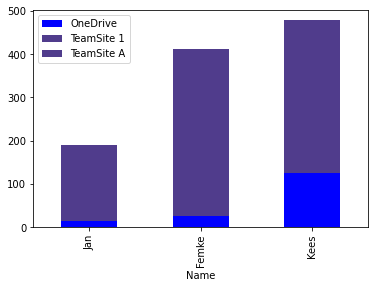

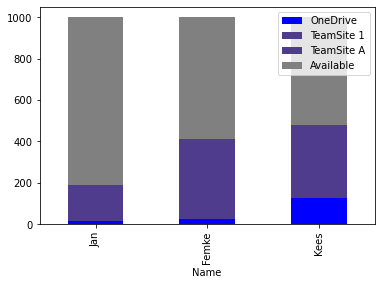

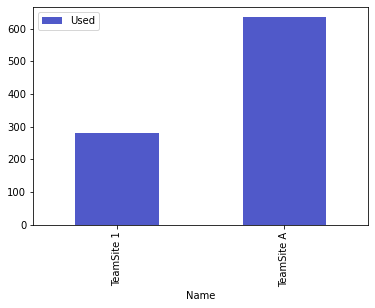

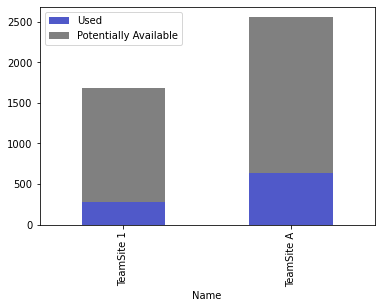

In [2]:
SE = storage_environment()

jan = user("Jan", SE, 15)
femke = user("Femke", SE, 25)
kees = user("Kees", SE, 125)

ts1 = storage_space("TeamSite 1", SE)
tsA = storage_space("TeamSite A", SE)

SE.add_storage_space(ts1)
SE.add_storage_space(tsA)

jan.add_storage_membership(ts1.name, 50)
jan.add_storage_membership(tsA.name, 125)
#jan.pp_storage_usage()
#jan.pp_evaluate_storage()
#jan.total_usage_plot()
#jan.usage_by_service_plot()
#jan.usage_by_service_plot(show_available=True)

femke.add_storage_membership(ts1.name, 230)
femke.add_storage_membership(tsA.name, 156)
#femke.pp_storage_usage()
#femke.usage_by_service_plot()

kees.add_storage_membership(tsA.name, 353)
#kees.usage_by_service_plot()

#ts1.evaluate_storage()
#print(ts1.potential)
#ts1.usage_plot()

SE.members_usage_plot()
SE.members_usage_plot(show_available=True)

SE.services_usage_plot()
SE.services_usage_plot(show_available=True)